# Imports

In [766]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import urllib
from PIL import Image
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.spatial import KDTree
import webcolors

import os

from webcolors import CSS3_HEX_TO_NAMES

# Scrape Wikipedia for flags and download

In [767]:
def get_flags():
    site="https://en.wikipedia.org/wiki/Gallery_of_sovereign_state_flags"
    result = requests.get(site)
    soup=BeautifulSoup(result.text, 'html.parser')
    #print(soup.prettify()[:500])
    divs=soup.findAll('div', class_="mod-gallery mod-gallery-default")
    f=[]
    for x in divs:
        for y in x.findAll('img'):
            f.append(y)
    flags=[x.get('src') for x in f]
    #flags
    for u in flags:
        url='https:'+u
        #print(url)
        p=url.split('/')[-1]
        urllib.request.urlretrieve(url, 'flags/'+p)

In [768]:
#Wikipedia get annoyed with a lot of scraping, only do it the firt ime
#get_flags()

# Analyse colours in flags

## Get list of colours

In [769]:
colour_list=[]
# Read in flag images and measure pixel count by colour
for i in os.listdir('flags'):
    im = Image.open('flags/'+i)
    rgbimg = im.convert('RGBA')
    my_dict={}
    size=0
    for pixel in rgbimg.getdata():
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    #Remove colours present in small amounts due to aliasing
    for k, v in dict(my_dict).items():
        if v<100:
            my_dict.pop(k)
        else:
            colour_list.append(k)

In [770]:
#Remove transparent pixels due to shape of Nepalese flag
colour_list.remove((0, 0, 0, 0))
colour_list

[(35, 159, 64, 255),
 (60, 170, 86, 255),
 (133, 202, 149, 255),
 (183, 223, 192, 255),
 (208, 234, 214, 255),
 (255, 255, 255, 255),
 (218, 0, 0, 255),
 (247, 200, 200, 255),
 (235, 114, 114, 255),
 (0, 0, 0, 255),
 (206, 17, 38, 255),
 (255, 255, 255, 255),
 (0, 122, 61, 255),
 (255, 255, 255, 255),
 (255, 0, 0, 255),
 (255, 255, 255, 255),
 (220, 20, 60, 255),
 (255, 255, 255, 255),
 (1, 33, 105, 255),
 (200, 16, 46, 255),
 (105, 179, 231, 255),
 (73, 151, 208, 255),
 (195, 221, 240, 255),
 (255, 255, 255, 255),
 (0, 158, 96, 255),
 (168, 192, 47, 255),
 (252, 209, 22, 255),
 (188, 179, 80, 255),
 (58, 117, 196, 255),
 (255, 255, 255, 255),
 (84, 122, 195, 255),
 (0, 57, 166, 255),
 (70, 52, 121, 255),
 (213, 43, 30, 255),
 (116, 172, 223, 255),
 (209, 227, 244, 255),
 (255, 255, 255, 255),
 (209, 228, 244, 255),
 (0, 122, 94, 255),
 (206, 17, 38, 255),
 (252, 209, 22, 255),
 (0, 56, 147, 255),
 (220, 20, 60, 255),
 (255, 255, 255, 255),
 (255, 255, 255, 255),
 (218, 18, 26, 255),
 

## Cluster colours for names

In [771]:
colours=pd.DataFrame(colour_list, columns=['R', 'G', 'B', 'A'])
#colours=colours.drop('A', axis=1)
colours

,R,G,B,A
0,35,159,64,255
1,60,170,86,255
2,133,202,149,255
3,183,223,192,255
4,208,234,214,255
...,...,...,...,...
782,0,92,229,255
783,255,0,0,255
784,255,255,255,255
785,127,160,141,255


In [772]:
k_range = range(5, 15)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(colours)
    scores.append(metrics.silhouette_score(colours, kmT.labels_))
    inertia.append(kmT.inertia_)

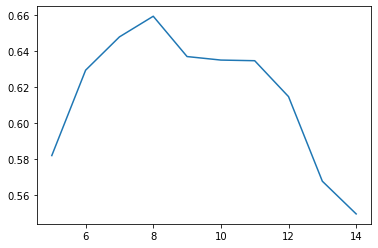

In [773]:
plt.plot(k_range, scores)

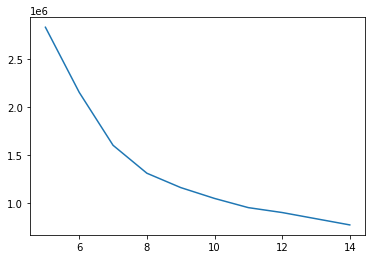

In [774]:
plt.plot(k_range, inertia)

In [775]:
km_colours = KMeans(n_clusters=10, random_state=124)
km_colours.fit(colours[['R', 'G', 'B']])

KMeans(n_clusters=10, random_state=124)

In [776]:
base_colours=km_colours.cluster_centers_
col_id=[x for x in range(0, len(base_colours))]

In [777]:
fig = px.imshow([base_colours])
fig.show()

In [778]:
colours['cluster']=km_colours.labels_
colours['cluster']=colours['cluster'].astype(str)
colours

,R,G,B,A,cluster
0,35,159,64,255,1
1,60,170,86,255,9
2,133,202,149,255,7
3,183,223,192,255,7
4,208,234,214,255,7
...,...,...,...,...,...
782,0,92,229,255,4
783,255,0,0,255,3
784,255,255,255,255,2
785,127,160,141,255,9


In [779]:
color_discrete_map={}
for i in range(0, len(base_colours)):
    color_discrete_map[str(i)]='rgb('+str(round(base_colours[i][0]))+','+str(round(base_colours[i][1]))+','+str(round(base_colours[i][2]))+')'

In [780]:
color_discrete_map

{'0': 'rgb(248,203,16)',
 '1': 'rgb(9,136,58)',
 '2': 'rgb(254,254,254)',
 '3': 'rgb(211,22,35)',
 '4': 'rgb(55,145,206)',
 '5': 'rgb(8,51,138)',
 '6': 'rgb(0,1,1)',
 '7': 'rgb(201,196,195)',
 '8': 'rgb(219,119,106)',
 '9': 'rgb(86,120,70)'}

In [781]:
fig=px.scatter_ternary(colours, a='R', b='G', c='B', color='cluster', color_discrete_map=color_discrete_map)
fig.show()

In [782]:
#km_colours.predict([[230, 180, 90]])[0]

### Read flags in

In [783]:
cols=col_id
cols

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [784]:
df=pd.DataFrame(columns=['Country', 'file']+cols)
#df.set_index('Country')
df

,Country,file,0,1,2,3,4,5,6,7,8,9


In [785]:
flag_list={}
for i in os.listdir('flags'):
    colour_percentage=[0]*(len(cols))
    name=re.search('Flag_of_(.+)\.svg', i).groups()[0]
    im = Image.open('flags/'+i)
    rgbimg = im.convert('RGB')
    my_dict={}
    size=0
    for pixel in rgbimg.getdata():
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    for k, v in dict(my_dict).items():
        if v<100:
            my_dict.pop(k)
        else:
            colour_list.append(k)
            flag_colour_id=km_colours.predict([k])[0]
            colour_percentage[flag_colour_id]+=v
    colour_percentage=[x/size for x in colour_percentage]
    #print(colour_percentage)
    df.loc[len(df)] =[name, i]+colour_percentage

/usr/lib/python3.9/site-packages/PIL/Image.py:962: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [786]:
df

,Country,file,0,1,2,3,4,5,6,7,8,9
0,Iran,175px-Flag_of_Iran.svg.png,0.000000,0.271371,0.316686,0.274343,0.000000,0.000000,0.000000,0.0304,0.009086,0.005829
1,Jordan,180px-Flag_of_Jordan.svg.png,0.000000,0.275926,0.194753,0.238827,0.000000,0.000000,0.275926,0.0000,0.000000,0.000000
2,Georgia,150px-Flag_of_Georgia.svg.png,0.000000,0.000000,0.631600,0.345467,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
3,Poland,160px-Flag_of_Poland.svg.png,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
4,Fiji,180px-Flag_of_Fiji.svg.png,0.000000,0.000000,0.081173,0.102222,0.648704,0.063951,0.000000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
201,Saint_Lucia,180px-Flag_of_Saint_Lucia.svg.png,0.064321,0.000000,0.020864,0.000000,0.853704,0.000000,0.029568,0.0000,0.000000,0.000000
202,Belize,167px-Flag_of_Belize.svg.png,0.000000,0.000000,0.036108,0.200000,0.000000,0.632814,0.000000,0.0000,0.000000,0.000000
203,Colombia,150px-Flag_of_Colombia.svg.png,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.0000,0.000000,0.000000
204,Slovenia,180px-Flag_of_Slovenia.svg.png,0.000000,0.000000,0.319444,0.333333,0.329444,0.000000,0.000000,0.0000,0.000000,0.000000


## Clean up names

## Cluster

In [787]:
b=df[[x for x in range(0, len(cols))]]

In [788]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(b)
    scores.append(metrics.silhouette_score(b, kmT.labels_))
    inertia.append(kmT.inertia_)

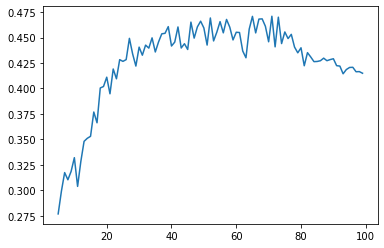

In [789]:
plt.plot(k_range, scores)

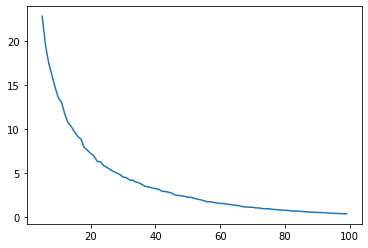

In [790]:
plt.plot(k_range, inertia)

In [791]:
cluster_size=30

In [792]:
km = KMeans(n_clusters=cluster_size)
km.fit(b)

KMeans(n_clusters=30)

In [793]:
df['cluster']=km.labels_

In [794]:
df

,Country,file,0,1,2,3,4,5,6,7,8,9,cluster
0,Iran,175px-Flag_of_Iran.svg.png,0.000000,0.271371,0.316686,0.274343,0.000000,0.000000,0.000000,0.0304,0.009086,0.005829,4
1,Jordan,180px-Flag_of_Jordan.svg.png,0.000000,0.275926,0.194753,0.238827,0.000000,0.000000,0.275926,0.0000,0.000000,0.000000,1
2,Georgia,150px-Flag_of_Georgia.svg.png,0.000000,0.000000,0.631600,0.345467,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,9
3,Poland,160px-Flag_of_Poland.svg.png,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,18
4,Fiji,180px-Flag_of_Fiji.svg.png,0.000000,0.000000,0.081173,0.102222,0.648704,0.063951,0.000000,0.0000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Saint_Lucia,180px-Flag_of_Saint_Lucia.svg.png,0.064321,0.000000,0.020864,0.000000,0.853704,0.000000,0.029568,0.0000,0.000000,0.000000,29
202,Belize,167px-Flag_of_Belize.svg.png,0.000000,0.000000,0.036108,0.200000,0.000000,0.632814,0.000000,0.0000,0.000000,0.000000,6
203,Colombia,150px-Flag_of_Colombia.svg.png,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.0000,0.000000,0.000000,27
204,Slovenia,180px-Flag_of_Slovenia.svg.png,0.000000,0.000000,0.319444,0.333333,0.329444,0.000000,0.000000,0.0000,0.000000,0.000000,15


In [795]:
c=[]
for i in range(0, cluster_size):
    c.append(df[df['cluster']==i]['Country'].tolist())
c

[['South_Ossetia', 'Artsakh', 'Seychelles'],
 ['Jordan',
  'Afghanistan',
  'South_Sudan',
  'the_Sahrawi_Arab_Democratic_Republic',
  'Malawi',
  'the_United_Arab_Emirates',
  'Saint_Kitts_and_Nevis',
  'Palestine',
  'Vanuatu',
  'Libya',
  'Kenya'],
 ['Fiji',
  'Guatemala',
  'Argentina',
  'the_Democratic_Republic_of_the_Congo',
  'Tuvalu',
  'Botswana',
  'Nicaragua'],
 ['Trinidad_and_Tobago',
  'Denmark',
  'the_People%27s_Republic_of_China',
  'Switzerland',
  'Turkey',
  'Tonga',
  'Albania',
  'Morocco',
  'Kyrgyzstan',
  'Latvia',
  'the_Republic_of_China',
  'Vietnam',
  'Tunisia',
  'Montenegro',
  'East_Timor',
  'Samoa'],
 ['Iran',
  'Niger',
  'Madagascar',
  'Kuwait',
  'Tajikistan',
  'Mexico',
  'Burundi',
  'Oman',
  'Somaliland',
  'Equatorial_Guinea',
  'Bulgaria',
  'Italy'],
 ['Burkina_Faso', 'Guyana', 'Mauritania'],
 ['the_Cook_Islands',
  'Kosovo',
  'Australia_%28converted%29',
  'Honduras',
  'Nauru',
  'the_Marshall_Islands',
  'Cape_Verde',
  'El_Salvador',

In [796]:
def merge_images(image1, image2):
    #image1=Image.open(file1)
    #image2=Image.open(file2)
    (width1, height1)=image1.size
    (width2, height2)=image2.size
    result_width=width1+width2
    result_height=max(height1, height2)
    result=Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0,0))
    result.paste(im=image2, box=(width1,0))
    return result

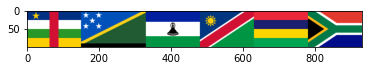

In [797]:
z=df[df['cluster']==23]['file'].tolist()
end=merge_images(Image.open('flags/'+z[0]), Image.open('flags/'+z[1]))
plt.imshow(end)
for i in range(2, len(z)):
    im = Image.open('flags/'+str(z[i]))
    end=merge_images(end, im)
plt.imshow(end)